In [1]:
import glob
import os
import sys

import matplotlib
import matplotlib.pyplot as plt

params = {"axes.titlesize": "26", "xtick.labelsize": "20", "ytick.labelsize": "20"}
matplotlib.rcParams.update(params)

import numpy as np
import pandas as pd
import rasterio as rio

sys.path.append(os.path.join(os.path.abspath(""), "../"))
from utils.raster_utils import get_coord_from_raster


MASKS_ROOT = "/data"
ROI_LIST = ["1158_spring", "1868_summer", "1970_fall", "2017_winter"]
SENSOR = "lc"
BANDS = ["IGBP", "LCCS_LC", "LCCS_LU", "LCCS_SH"]
BANDS_VALS = {
    "IGBP": [i for i in range(18)] + [255],
    "LCCS_LC": [1, 2, 3]
    + [i for i in range(11, 17)]
    + [21, 22, 31, 32, 41, 42, 43, 255],
    "LCCS_LU": [1, 2, 3, 9, 10, 20, 25, 30, 35, 36, 40, 255],
    "LCCS_SH": [1, 2, 3, 10, 20, 27, 30, 40, 50, 51, 255],
}
BANDS_ACC = [0.67, 0.74, 0.81, 0.87]

METADATA_PATH = "/data/masks_metadata.csv"

### Generate masks metadata

In [2]:
# Grab list of all subgrids
areas_ROI = {val: 0 for val in ROI_LIST}
for ROI in ROI_LIST:
    roi_folder = os.path.join(MASKS_ROOT, f"ROIs{ROI}")
    areas = glob.glob(os.path.join(roi_folder,"*"))
    areas = set([int(os.path.split(path)[1].split("_")[1]) for path in areas])
    areas_ROI[ROI] = areas

if os.path.isfile(METADATA_PATH):
    df = pd.read_csv(METADATA_PATH, index_col=0)
else:
    dfs = []
    for ROI in ROI_LIST:
        for i, area in enumerate(areas_ROI[ROI]):
            data_path = os.path.join(MASKS_ROOT, f"ROIs{ROI}", f"{SENSOR}_{area}")
            files = glob.glob(os.path.join(data_path, "*tif"))
            for j, file in enumerate(files):
                df_cols = []
                df_vals = []
                src = rio.open(file)
                img = np.array([src.read(i + 1) for i in range(src.count)])

                df_cols.extend(["filepath", "filename", "ROI", "area"])
                df_vals.extend([file, os.path.splitext(os.path.split(file)[1])[0], ROI, area])
                df_cols.extend(["x0", "y0", "x1", "y1"])
                df_vals.extend(get_coord_from_raster(src))
                
                for band in range(4):
                    vals, counts = np.unique(img[band, :, :], return_counts=True)
                    for val, count in zip(vals, counts):
                        df_cols.append(f"{BANDS[band]}_{val}")
                        df_vals.append(count)

                df = pd.DataFrame(np.array(df_vals).reshape(1,-1), columns=df_cols)
                dfs.append(df)
                j += 1
            i += 1

    df = pd.concat(dfs)
    df.fillna(0, inplace=True)

    df.reset_index(inplace=True, drop=True)
    cat_cols = ['filepath', 'filename', 'ROI', 'area']
    float_cols = ['x0', 'y0', 'x1', 'y1']
    int_cols = [key for key in df.keys() if key not in cat_cols and key not in float_cols]
    df[float_cols] = df[float_cols].astype(np.float)
    df[int_cols] = df[int_cols].astype(np.int32)

    df.to_csv(METADATA_PATH, index_label="No")

In [3]:
df.head()

,filepath,filename,ROI,area,x0,y0,x1,y1,IGBP_9,IGBP_11,...,LCCS_SH_15,LCCS_LU_0,LCCS_LC_24,LCCS_LU_23,LCCS_SH_22,LCCS_LC_39,LCCS_LU_37,LCCS_SH_37,LCCS_LU_16,LCCS_SH_34
No,,,,,,,,,,,,,,,,,,,,,
0,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p81,1158_spring,128,600796.364733,6.094633e+06,603356.364733,6.092073e+06,15676,1723,...,0,0,0,0,0,0,0,0,0,0
1,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p48,1158_spring,128,595676.364733,6.095913e+06,598236.364733,6.093353e+06,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p660,1158_spring,128,599516.364733,6.069033e+06,602076.364733,6.066473e+06,11127,0,...,0,0,0,0,0,0,0,0,0,0
3,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p755,1158_spring,128,572636.364733,6.063913e+06,575196.364733,6.061353e+06,42783,0,...,0,0,0,0,0,0,0,0,0,0
4,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p834,1158_spring,128,599516.364733,6.061353e+06,602076.364733,6.058793e+06,2148,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(df.dtypes)

filepath       object
filename       object
ROI            object
area            int64
x0            float64
               ...   
LCCS_LC_39      int64
LCCS_LU_37      int64
LCCS_SH_37      int64
LCCS_LU_16      int64
LCCS_SH_34      int64
Length: 76, dtype: object


In [5]:
df.shape

(180662, 76)

### Plot labels distribution

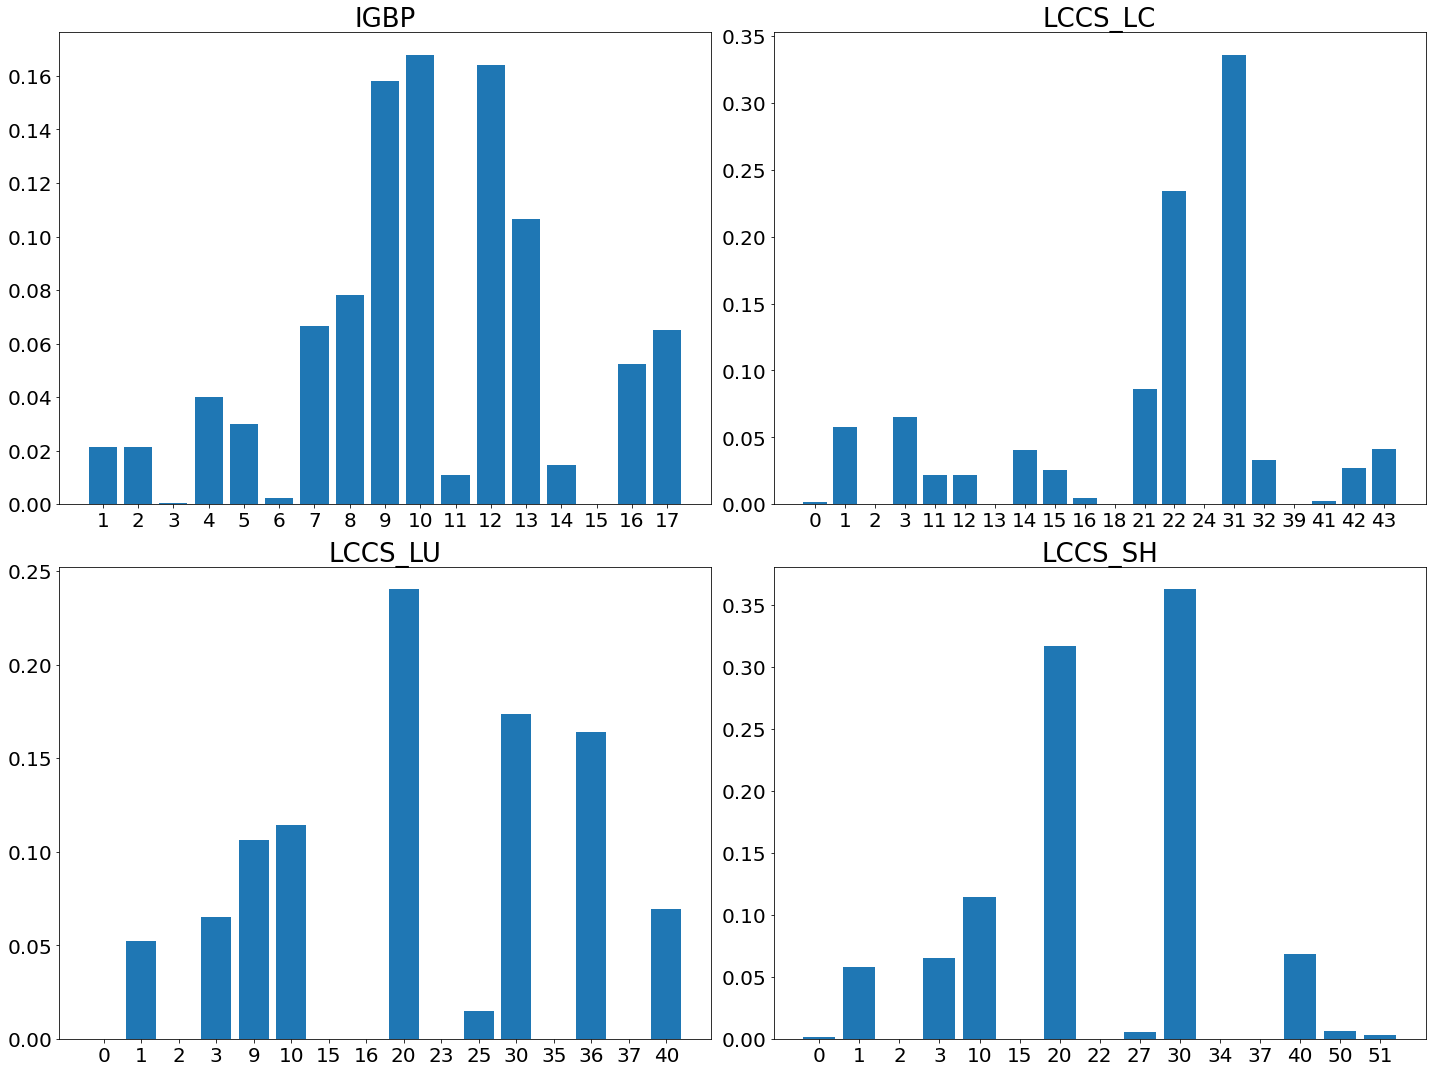

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax = ax.flatten()
for i, band in enumerate(BANDS):
    cols = [key for key in df.keys() if band in key]
    cols = sorted(cols, key = lambda x: int(x.split("_")[-1]))
    df_temp = df[cols]
    df_temp = df_temp.sum(axis=0)
    vals = [val.split("_")[-1] for val in list(df_temp.index)]
    counts = list(df_temp.values)

    counts = counts / np.sum(counts)
    ax[i].bar(vals, counts, label=band)
    ax[i].set_title(band)
plt.tight_layout()

In [18]:
# Check what kind of LCCS SH labels are in selected LCCS LU labels

# Urban
df_temp = df[(df["LCCS_LU_9"] > 65000)]
LCCS_SH_cols = [key for key in df_temp.keys() if "LCCS_SH" in key]
labels_count = df_temp[LCCS_SH_cols].sum()
labels_count = labels_count / labels_count.sum()
print(labels_count)


LCCS_SH_3     0.000049
LCCS_SH_20    0.613504
LCCS_SH_27    0.000041
LCCS_SH_1     0.092921
LCCS_SH_30    0.252009
LCCS_SH_10    0.001928
LCCS_SH_50    0.001049
LCCS_SH_51    0.003812
LCCS_SH_0     0.022822
LCCS_SH_40    0.011495
LCCS_SH_2     0.000369
LCCS_SH_15    0.000000
LCCS_SH_22    0.000000
LCCS_SH_37    0.000000
LCCS_SH_34    0.000000
dtype: float64


In [19]:
df_temp = df[(df["LCCS_LU_25"] > 65000) | (df["LCCS_LU_35"] > 65000) | (df["LCCS_LU_36"] > 65000)]
CCS_SH_cols = [key for key in df_temp.keys() if "LCCS_SH" in key]
labels_count = df_temp[LCCS_SH_cols].sum()
labels_count = labels_count / labels_count.sum()
print(labels_count)

LCCS_SH_3     2.721285e-06
LCCS_SH_20    1.641356e-03
LCCS_SH_27    0.000000e+00
LCCS_SH_1     2.558973e-07
LCCS_SH_30    9.983390e-01
LCCS_SH_10    2.178783e-06
LCCS_SH_50    2.471237e-07
LCCS_SH_51    5.761344e-07
LCCS_SH_0     0.000000e+00
LCCS_SH_40    1.369416e-05
LCCS_SH_2     0.000000e+00
LCCS_SH_15    0.000000e+00
LCCS_SH_22    0.000000e+00
LCCS_SH_37    0.000000e+00
LCCS_SH_34    0.000000e+00
dtype: float64


For urban area, 87% of LCCS_SH is Forest area. For croplands, 99% of LCCS_SH is Forest area.
We have a lot of Forest labels, so let's proceed with it.